# Importing Packages

In [108]:
# data handling
import numpy as np
import pandas as pd

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
import plotly as py
import plotly.graph_objs as go
from kneed import KneeLocator

# machine learning
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import silhouette_score

# Motivation

The goal is to effectively visualize data and create a K-Means clustering model using sklearn. There is an emphasis here on creating deduceable plots that serve as educational tools to further my own understadning of both the data and the algorithm itself.

# Data Exploration

In [109]:
df = pd.read_csv('Mall_Customers.csv')

df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [110]:
df.shape

(200, 5)

In [111]:
df.dtypes

CustomerID                 int64
Gender                    object
Age                        int64
Annual Income (k$)         int64
Spending Score (1-100)     int64
dtype: object

In [112]:
# we also want to check if our data has any null values
df.isnull().sum()

CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

This saves us some extra work in the pre-processing phase, as we don't have to handle any missing values.

In [113]:
df.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


Here, we can see that quartiles of our data and it might be of interest to plot these on a histogram.

# Data Visualization

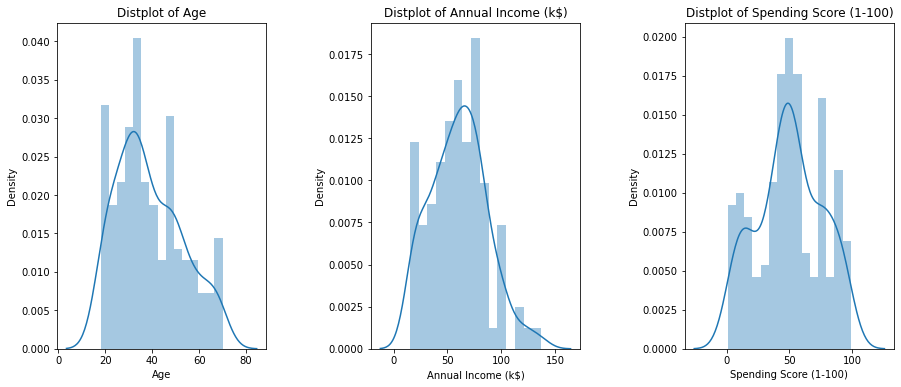

In [114]:
plt.figure(1, figsize=(15,6))

n = 0

for plot in ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']:
    n += 1
    plt.subplot(1, 3, n)
    plt.subplots_adjust(hspace = 0.5, wspace = 0.5)
    sns.distplot(df[plot], bins = 15)
    plt.title('Distplot of {}'.format(plot))

plt.show()

We can see that our plots for age and annual income might be skewed left.

In [115]:
print("The skewness of age is:", df['Age'].skew())
print("The skewness of the anuual income is:", df['Annual Income (k$)'].skew())
print("The skewness of the spending score is:", df['Spending Score (1-100)'].skew())

The skewness of age is: 0.48556885096681657
The skewness of the anuual income is: 0.3218425498619055
The skewness of the spending score is: -0.047220201374263374


A quick analysis of the skewness reveals that our data is fairly symmetrical.

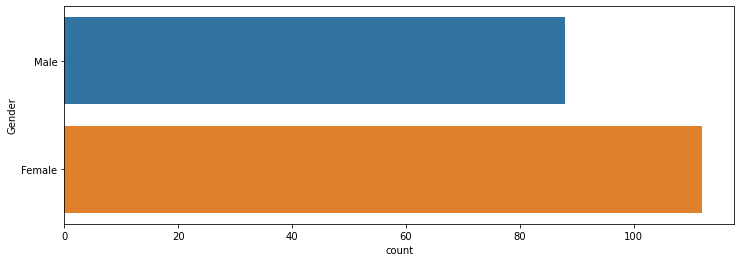

In [116]:
plt.figure(1, figsize=(12,4))
sns.countplot(y = 'Gender', data=df)
plt.show()

Our dataset isn't fairly large, therefore we shouldn't need to worry about dimensionality reduction, but it could be helpful to scale the data.

We can most likely assume we have a Gaussian distribution, so we can use the StandardScaler class from sklearn to do so.

In [117]:
# renaming columns for ease of use
df.rename(columns={
          'Gender':'gender', 
          'Age':'age', 
          'Annual Income (k$)':'income', 
          'Spending Score (1-100)':'spending score', 
          'CustomerID':'id'})

,id,gender,age,income,spending score
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40
...,...,...,...,...,...
195,196,Female,35,120,79
196,197,Female,45,126,28
197,198,Male,32,126,74
198,199,Male,32,137,18


### Building a (Simple) Preprocessing Pipeline

In [118]:
# setting our features for only age, income, and spending score
x = df.iloc[:, [2,4]].values

In [119]:
preprocessor = Pipeline(
    [
        ('scaler', StandardScaler())
    ])

In [120]:
scaled_features = preprocessor.fit_transform(x)

Yes, this is barely a pipeline, but I wanted to get the general feel for coding one. In practice, we could also add other components to the preprocessing pipeline such as PCA but that is not needed here.

# K-Means Clustering

### Elbow Method for Determining K

In [121]:
kmean_kwargs = {
    'init': 'random',
    'n_init': 25,
    'max_iter': 100,
    'random_state': None,  
}

sse = []

for k in range(1,11):
    kmeans = KMeans(n_clusters=k, **kmean_kwargs)
    kmeans.fit(scaled_features)
    sse.append(kmeans.inertia_)

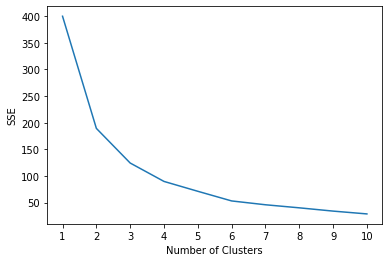

In [122]:
plt.plot(range(1,11), sse)
plt.xticks(range(1,11))
plt.xlabel('Number of Clusters')
plt.ylabel('SSE')
plt.show()

The 'elbow point' here is a bit ambiguous, although we could feel confident with a choice such as 2 or 3. However, we can use 'kneed' to compute it and give us a solid answer.

In [123]:
kl = KneeLocator(
    range(1,11), sse, curve='convex', direction='decreasing')

print("Our elbow is:", kl.elbow)

Our elbow is: 3


Okay cool, now we can be confident with our choice.

### Silhouette Coefficient for Determining K

In [124]:
silhouette_coefficients = []

for k in range(2,11):
    kmeans = KMeans(n_clusters=k, **kmean_kwargs)
    kmeans.fit(scaled_features)
    score = silhouette_score(scaled_features, kmeans.labels_)
    silhouette_coefficients.append(score)

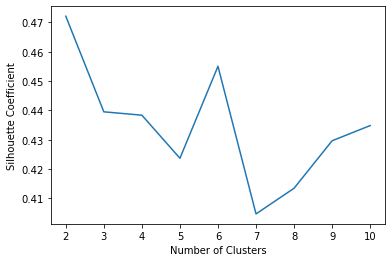

In [125]:
plt.plot(range(2,11), silhouette_coefficients)
plt.xticks(range(2,11))
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Coefficient')
plt.show()

Given the plot, we can see that there is a spike at k=6, however, k=3 isn't a terrible choice and it might not be terrible if we were to try both in our final model.

### Building Our Model

In [126]:
model = KMeans(n_clusters=3, init='k-means++', n_init=25, max_iter=100, random_state=None)

y_kmeans = model.fit_predict(scaled_features)

# Plotting the Clusters

In [127]:
labels = model.labels_
centroids = model.cluster_centers_

df['label'] =  labels
trace1 = go.Scatter3d(
    x = df['Age'],
    y = df['Spending Score (1-100)'],
    z = df['Annual Income (k$)'],
    mode='markers',
     marker=dict(
        color = df['label'], 
        size= 20,
        line=dict(
            color= df['label'],
            width= 12
        ),
        opacity=0.8
     )
)

data = [trace1]
layout = go.Layout(
    title= 'Clusters',
    scene = dict(
            xaxis = dict(title  = 'Age'),
            yaxis = dict(title  = 'Spending Score'),
            zaxis = dict(title  = 'Annual Income')
        )
)

fig = go.Figure(data=data, layout=layout)
py.offline.iplot(fig)